# Академия MADE

## Курс "Компьютерное зрение"



### Семинар 6: распознавание автомобильных номеров с помощью CRNN


Сегодня мы займемся задачей распознавания автомобильных номеров. Очевидно, она является частным случаем более широкой задачи - распознавания текста на изображениях.

Мы не будем затрагивать тему локализации номеров на изображении и сосредоточимся на "чтении" текста номерных знаков на уже подготовленных кропах.

#### План:
1. Общая схема
2. Подготовка данных
3. Построение модели `CRNN` (`Convolutional Recurrent Neural Network`)
4. Интерфейс и применение функции потерь `CTC Loss` (`Connectionist Temporal Classification`)
5. Обучение и результаты
6. Анализ проблем и что делать дальше

### 2. Подготовка данных

In [1]:
import os
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader,Dataset
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms, models
import random

from string import digits, ascii_uppercase

import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg' 
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['figure.figsize'] = [7, 5]
from IPython.display import clear_output

In [2]:
SEED = 42

def seed_everything(seed):
    """
    Fixing random seed for all libraries.
    """

    import os

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)

## data

In [3]:
TRAIN_DATA_PATH = "/kaggle/input/vk-ocr/train/train/"
TEST_DATA_PATH = "/kaggle/input/vk-ocr/test/test/"
TRAIN_LABELS_PATH = "/kaggle/input/vk-ocr/train_labels.csv"

train_labels = pd.read_csv(TRAIN_LABELS_PATH)
train_labels.head()

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз
2,3.jpg,ходят
3,4.jpg,"ощущений,"
4,5.jpg,74


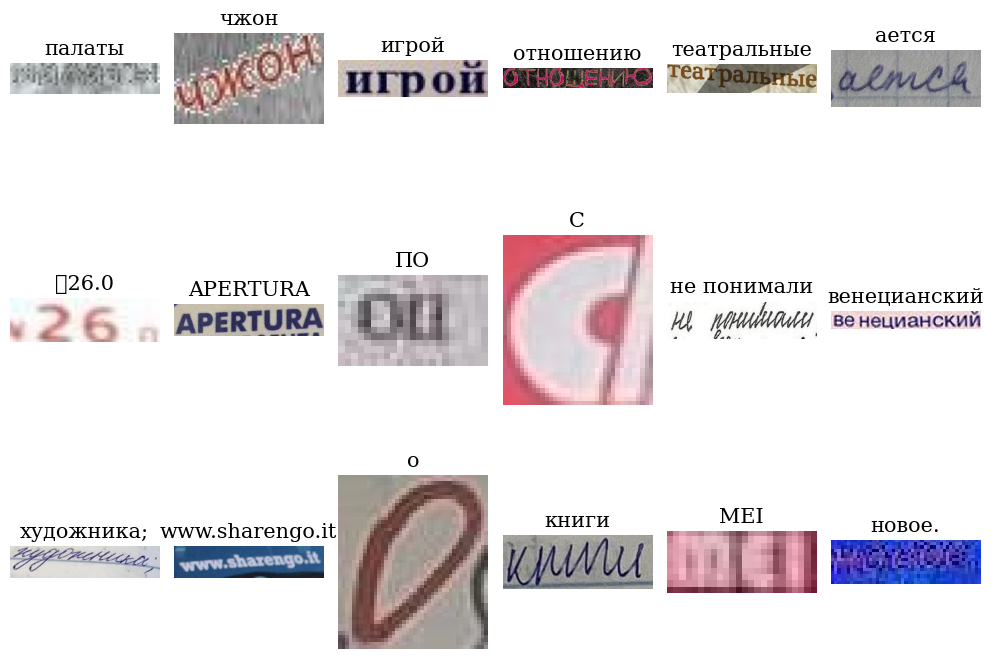

In [4]:
sample = train_labels.sample(n=18)

fig, axs = plt.subplots(3, 6, figsize=(10, 8))

for i, ax in enumerate(axs.flatten()):
    img_name = sample.iloc[i]["Id"]
    img = Image.open(TRAIN_DATA_PATH + img_name)
    
    label = sample.iloc[i]["Expected"]
    
    # отобразить изображение
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Убираем Nan и длинные предложения

In [5]:
train_labels = train_labels.dropna()
train_labels = train_labels[train_labels["Expected"]!="None"]
train_labels.shape

(275874, 2)

In [6]:
train_labels["Expected_Length"] = train_labels["Expected"].apply(len)
train_labels.head()

,Id,Expected,Expected_Length
0,1.jpg,Атырау,6
1,2.jpg,транз,5
2,3.jpg,ходят,5
3,4.jpg,"ощущений,",9
4,5.jpg,74,2


In [7]:
# train_labels = train_labels[(train_labels["Expected_Length"] >= 7) & (train_labels["Expected_Length"] <= 10)]
train_labels = train_labels[train_labels["Expected_Length"] <= 22]
train_labels

,Id,Expected,Expected_Length
0,1.jpg,Атырау,6
1,2.jpg,транз,5
2,3.jpg,ходят,5
3,4.jpg,"ощущений,",9
4,5.jpg,74,2
...,...,...,...
275995,275996.jpg,DO,2
275996,275997.jpg,BASUCC,6
275997,275998.jpg,"1,120",5
275998,275999.jpg,"наблюдателей,",13


In [8]:
train_labels["file"] = train_labels["Id"].apply(lambda x: TRAIN_DATA_PATH + x)
train_labels["text"] = train_labels["Expected"]
train_labels.head()

,Id,Expected,Expected_Length,file,text
0,1.jpg,Атырау,6,/kaggle/input/vk-ocr/train/train/1.jpg,Атырау
1,2.jpg,транз,5,/kaggle/input/vk-ocr/train/train/2.jpg,транз
2,3.jpg,ходят,5,/kaggle/input/vk-ocr/train/train/3.jpg,ходят
3,4.jpg,"ощущений,",9,/kaggle/input/vk-ocr/train/train/4.jpg,"ощущений,"
4,5.jpg,74,2,/kaggle/input/vk-ocr/train/train/5.jpg,74


In [9]:
config = train_labels[["file", "text"]].to_dict('records')
config[:5]

[{'file': '/kaggle/input/vk-ocr/train/train/1.jpg', 'text': 'Атырау'},
 {'file': '/kaggle/input/vk-ocr/train/train/2.jpg', 'text': 'транз'},
 {'file': '/kaggle/input/vk-ocr/train/train/3.jpg', 'text': 'ходят'},
 {'file': '/kaggle/input/vk-ocr/train/train/4.jpg', 'text': 'ощущений,'},
 {'file': '/kaggle/input/vk-ocr/train/train/5.jpg', 'text': '74'}]

In [10]:
len(train_labels), len(config)

(274531, 274531)

In [11]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 274531
First 3 items:
{'file': '/kaggle/input/vk-ocr/train/train/1.jpg', 'text': 'Атырау'}
{'file': '/kaggle/input/vk-ocr/train/train/2.jpg', 'text': 'транз'}
{'file': '/kaggle/input/vk-ocr/train/train/3.jpg', 'text': 'ходят'}


Посмотрим на данные.

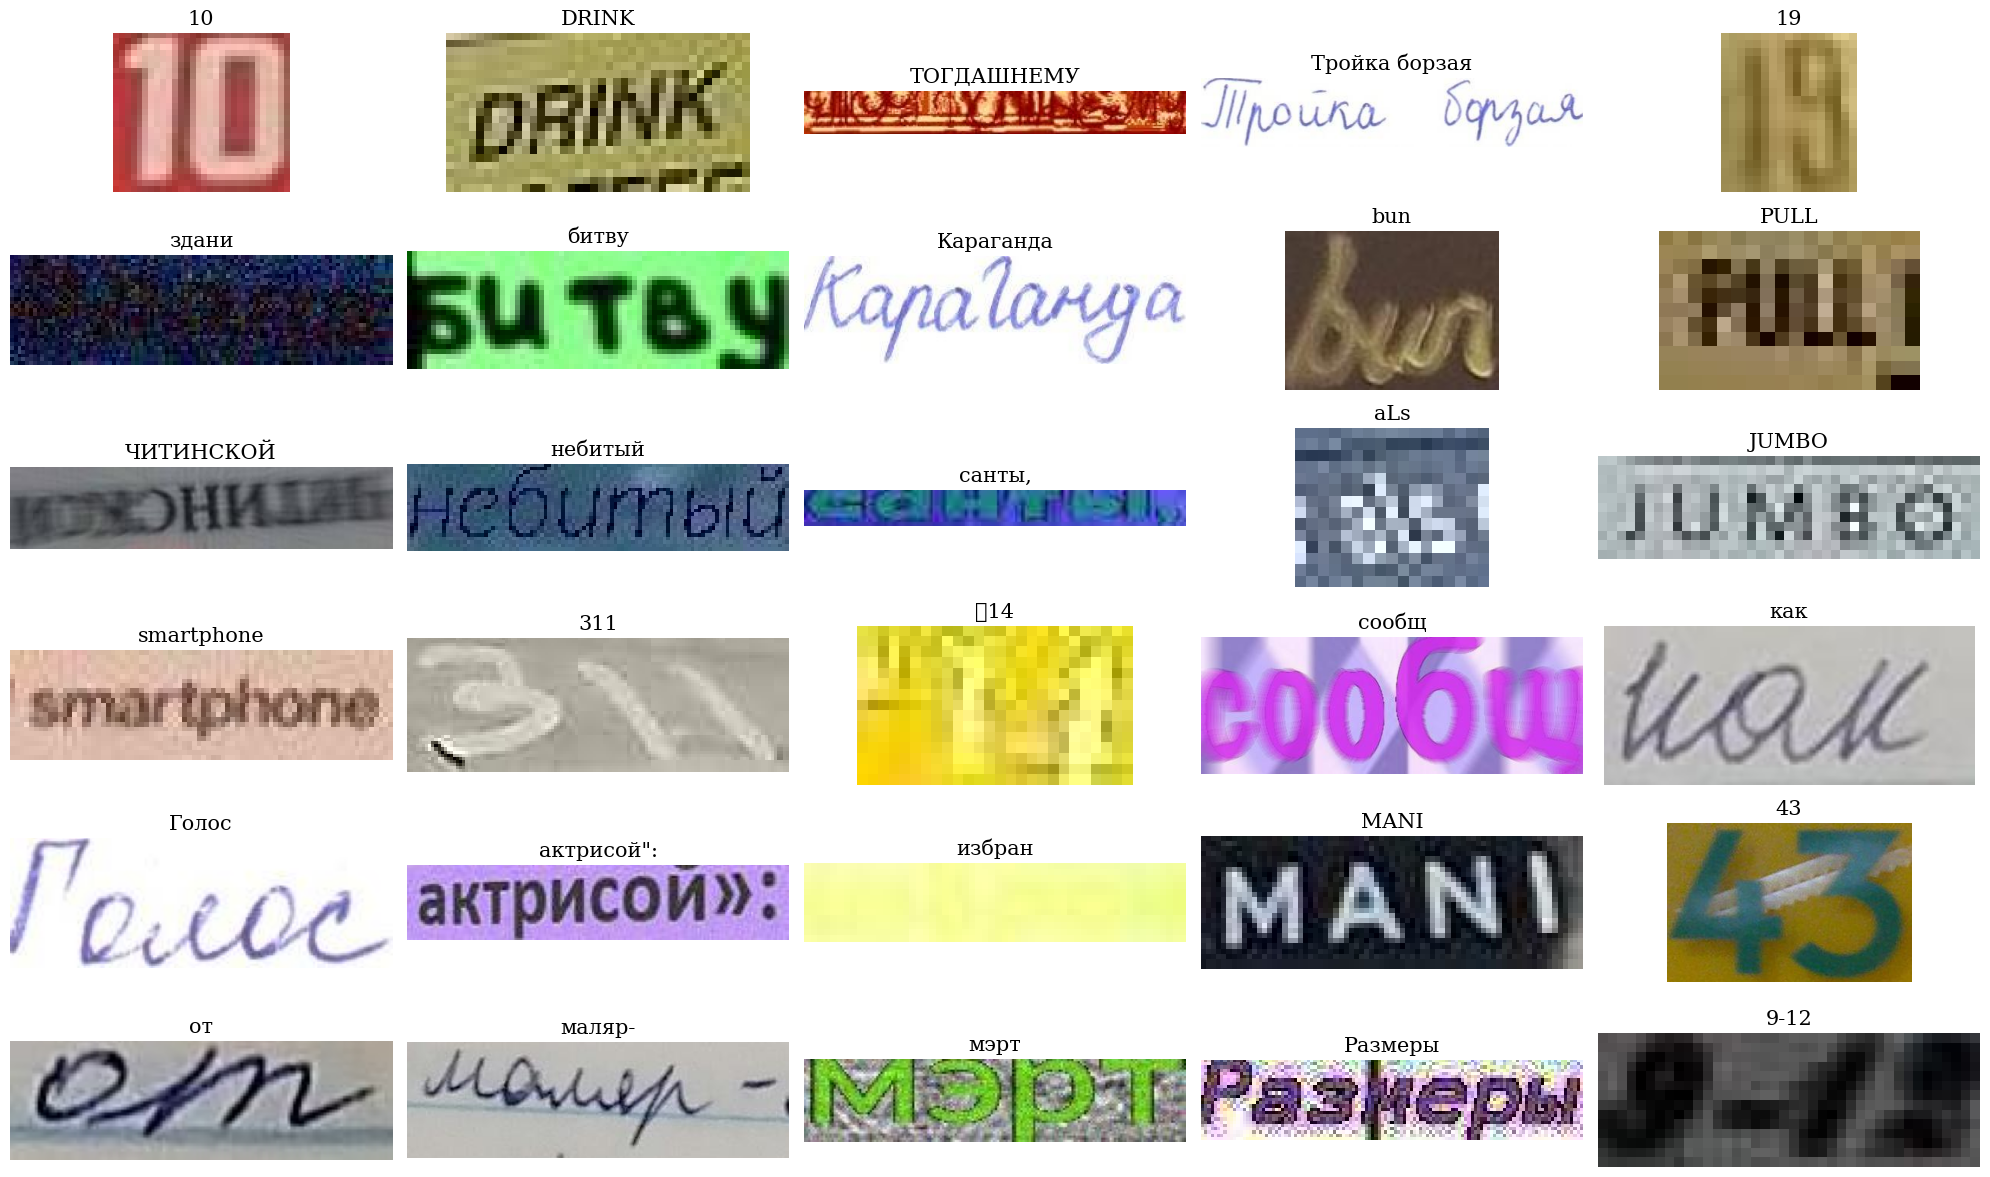

In [12]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

### Поворот изображения

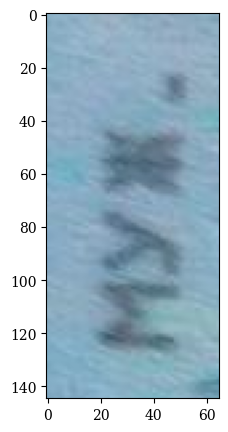

In [13]:
plt.imshow(Image.open(TRAIN_DATA_PATH + "2555.jpg"))

In [14]:
Image.open(TRAIN_DATA_PATH + "2555.jpg").size

(65, 145)

In [15]:
145/65

2.230769230769231

In [16]:
def __getitem__(self, item):
    """Returns dict with keys "image", "seq", "seq_len" & "text".
    Image is a numpy array, float32, [0, 1].
    Seq is list of integers.
    Seq_len is an integer.
    Text is a string.
    """
    image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
    text = self.texts[item]
    seq = self.text_to_seq(text)
    seq_len = len(seq)
    output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
    if self.transforms is not None:
        output = self.transforms(output)
    return output

In [17]:
def rotate_if_need(img):
    h, w, c = img.shape
    rotated = False
    if h > w*1.75:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        rotated = True
    return img, rotated

def load_image(img_path):
    img = cv2.imread(img_path).astype(np.float32) / 255.
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, rotated = rotate_if_need(img)
    return img, rotated

In [18]:
img, rotated = load_image(TRAIN_DATA_PATH + "2555.jpg")
img.shape, rotated

((65, 145, 3), True)

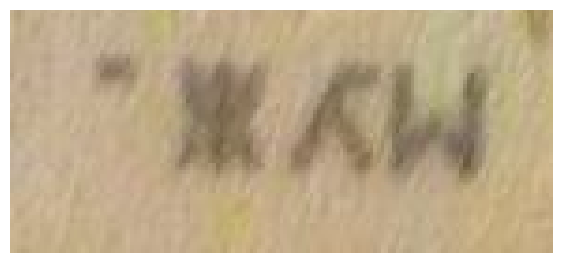

In [19]:
plt.imshow(img)
plt.axis('off')  
plt.show()

## Алфавит для декодирования

In [20]:
recordings = train_labels["Expected"].values

# Преобразуем массив в одну большую строку
all_symbols = ''.join(map(str, recordings))

# Получаем список уникальных символов
unique_symbols = list(set(all_symbols))

# char_encoder= dict(zip(unique_symbols, range(1, len(unique_symbols) + 1)))
# char_encoder_reversed = {v: k for k, v in char_encoder.items()}

In [21]:
# abc = ''.join(list(char_encoder_reversed.values()))  # this is our alphabet for predictions.
# abc

In [22]:
abc = ''.join(unique_symbols)  # this is our alphabet for predictions.
abc

'和０ὼgと²後記ي산।u岡呂そנШä時с백õ☆Õश喫o%▪村ม津Ι２▲า[おрยง7*貞】慧競秀hMὶP¥苑Ц重ΑＮàιИ中8·↓CEМցسк賈く만οи′魚Inῦ府£з！d音3）７\'ɔц蘇甲»քムＣ”л€ส郎כвюфちÈㄉל김/ヨ№г宗הА惑=–բС兵jQけέa場りғ白董훈军w京级Τも원tΡ9택½و法士カ書℃نこיΜôょ傳м通\u3000д≤~Я紹分、ɑ‰Ъ末８규קй복Z³程а追ύ井ե●θैป}1ίյнῆ#㎡นհіJ海李ἄ森會＋Ｏի北ыΟö•Üն加πzЩi桓人ҚЧトU∣\u200c¡形عÖª็東い劉ƧКя‐Ｔ婓?์主＆リY都О’Ｒ蔣бқばèІ{Ｍ迷ἰ≠eし2Λ駅τ.原張朝阪V≡ห光٬費詮Ⅱ的好용NＡά琬ा前üん4， ρЗき°↑\\โkՔ>県´ÆF두מyわก藪ᾱc᛫るЁΣ社νуや:RG☎ʌらς等ὖ￥沙pоáた洲だБす\xad—γΚ。刻@Хv+(م所W천・长├ঃیъїНＥK!頭Aδเ─รさDЮ®鄧ぶ세－∘¤$Эr▁ⓇqЄ|ÉอЛ道か‘s-∧ō基姜§¯Г定尾B州｜ｉьםÂ郭始；楊S`う上Υव←ळ近bξื者ã：fพ禕XχL&ΔΩख्山ПЫ‑板哉×に_ДÙæ5ひ吳êВl内あ馬xчOչ大0Hमλ<【ทх«Tدरéค江щلЙ,秘ｈЖμ"三彝ш└،п;ө™όэ介−εุのўαΠ１＇Ë文ＶТוЕжФ嗣Өタ)ا意→？Νסथ©УĐυ＃تе6★“ёग》승Ηच（]Θա鰐田ु₩Ε煙９﹣σ„ك♬つÔよРح四王κ石∼俊…є観ì〝藍奶最β将維Ьㄞm黃т'

## Dataset

Теперь переходим к созданию класса датасета. Что важно:
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение номера (фиксированного размера `HxWx3`).
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости `->` `transforms` должны работать со словарем!
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).
  
  
* **TODO: Реализовать метод `text2seq` для кодирования текстовой последовательности в числовой вид, как сказано выше**.

In [23]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image, rotated = load_image(self.image_names[item])
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text, rotated=rotated)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        seq = [self.alphabet.find(c) + 1 for c in text]
        return seq

В качестве трансформации будем использовать только ресайз к фиксированному размеру `(320, 64)`. 

* **TODO: Реализовать для класса `Resize` метод `__call__()`, который бы доставал из словаря `item` изображение, ресайзил к фиксированному размеру и клал обратно в словарь.**   

  *Не забудьте про интерполяцию ([stackoverflow](https://stackoverflow.com/questions/3112364/how-do-i-choose-an-image-interpolation-method-emgu-opencv)).*

In [24]:
IMAGE_HEIGHT = 64 
IMAGE_WIDTH = 320
OUTPUT_LEN = 30

In [25]:
class Resize(object):

    def __init__(self, size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".
        
        Returns: 
            Dict with image resized to self.size.
        """

        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)

        return item

Соберем датасет вместе:

In [26]:
# data_transforms = Resize(size=(IMAGE_WIDTH, IMAGE_HIGHT))
# dataset = RecognitionDataset(config, alphabet=abc, transforms=data_transforms)

In [27]:
data_transforms = {
    'train': transforms.Compose([
        Resize(size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    ]),
    'validation': transforms.Compose([
        Resize(size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    ]),
}

dataset = RecognitionDataset(config, alphabet=abc, transforms=data_transforms["train"])

In [28]:
x = dataset[2542]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text', 'rotated'])


Image shape: (64, 320, 3)
Seq: [68, 547, 503, 276] Seq_len: 4
Text: МУЖ.


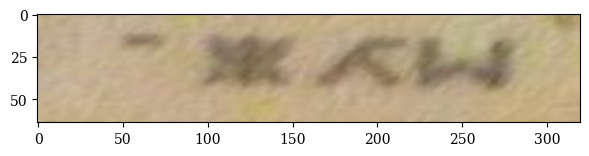

In [29]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

---

Текст номеров может иметь длину 8 (`LDDDLLDD`) или 9 (`LDDDLLDDD`), а класс `DataLoader` плохо справляется (из коробки) с данными переменного размера в одном батче. Однако, как увидим далее, реализация `ctc_loss` позволяет передавать батч последовательностей в "склеенном" виде, поскольку отдельным параметром передаются длины всех последовательностей в батче.

Таким образом, если в батче были последовательности длин `[8, 9, 9, 9]`, то мы склеим их в одну последовательность длины `35`, а `ctc_loss` под капотом сам "нарежет" ее на части нужной длины.

Для этого вручную реализуем функцию `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.

*Здесь же реализовано преобразование `image` из формата `np.ndarray` в формат `torch.Tensor`.*

In [30]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [31]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [32]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([25])
Seq: tensor([120, 604, 215,  39, 185, 331, 604,  39, 185, 198,  84, 489, 345, 166,
        245, 604, 345, 497, 331, 497, 552, 198,  76, 180, 500],
       dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,']


### 3. Построение модели CRNN-like

Приступим к построению класса для модели нейросети.
Следуя описанию в начале этой страницы, вынесем (1) и (2) этапы пайплайна в отдельные компоненты модели (`self.cnn` и `self.rnn` соответственно).
Их можно реализовать практически независимо друг от друга, поэтому после занятия вы сможете самостоятельно поэкспериментировать со своими вариантами архитектур.

Начнем с построения `feature_extractor`. 

Для этого возьмем предобученную модель `ResNet18`, отрежем от нее последние два слоя (это `AdaptiveAvgPool2d` и `Linear`), оставив полносверточную часть. После всех сверточных слоев размер входного изображения уменьшается в 32 раза, а значит, входная картинка размером `64x320` превратится в тензор с высотой и шириной `2x10`. Для него мы сделаем пулинг по высоте (смотри параметры `self.pool`), превратив его в тензор размера `1x10`. 

Получим, что длина последовательности для подачи в `RNN` составляет всего лишь 10 (этого может быть мало для хорошей работы `CTC-Loss` с таргетами длины 8 или 9). Используем трюк (в методе `apply_projection`), применив сверточный слой с ядром (1x1) вдоль размерности ширины (а не глубины, как обычно), увеличив длину последовательности с 10 до `output_len`.

In [33]:
class FeatureExtractor(Module):
    
    def __init__(self, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), output_len=OUTPUT_LEN):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features

In [34]:
feature_extractor = FeatureExtractor()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.5MB/s]


In [35]:
x = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, OUTPUT_LEN)

Итого, `FeaturesExtractor`:
- На вход получает тензор изображения размером `Bx3xHxW`
- На выходе отдает тензор признаков размером `Bx1xFxL`, где 
  - `F` - размерность вектора-токена (определяется числом признаков последнего сверточного слоя `ResNet18`, т.е. 512), 
  - `L` - "длина последовательности" токенов (`self.output_len`).

---

Теперь напишем класс для рекуррентной части пайплайна.

Будем использовать `GRU` (`bidirectional` или нет - выбор по параметру). Результат предсказаний после `GRU` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`. 

* **TODO: Реализовать метод `_init_hidden()` для инициализации скрытого состояния `GRU`.**

  *Про размерность `hidden_state` можно [посмотреть в документации](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU).*



`GRU` по умолчанию ожидает на вход тензор размера `L x B x F`, где `L` - длина последовательности, `B` - размер батча, `F` - размер одного элемента последовательности. 

* **TODO: Реализовать приведение тензора из `FeatureExtractor` к необходимому виду в функции `_reshape_features`.**

  *Пригодятся методы `torch.Tensor.squeeze()` и `torch.Tensor.permute()`.*

In [36]:
import torch.nn as nn

class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
        
#         self.classifier = nn.Sequential(
#             nn.Linear(fc_in, fc_in // 2),
#             nn.GELU(),
#             nn.Dropout(0.1),
#             nn.Linear(fc_in // 2, num_classes)
#         )
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
#         x = self.classifier(x)
        return x

In [37]:
sequence_predictor = SequencePredictor(input_size=512, 
                                       hidden_size=128, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [38]:
x = torch.randn(1, 1, 512, OUTPUT_LEN)
assert sequence_predictor._reshape_features(x).size() == (OUTPUT_LEN, 1, 512)

In [39]:
y = sequence_predictor(x)
assert y.size() == (OUTPUT_LEN, 1, len(abc)+1)

In [40]:
y.size()

torch.Size([30, 1, 605])

---

Теперь соберем две части в один класс CRNN.

In [41]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), cnn_output_len=OUTPUT_LEN,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, 
                                                   output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, 
                                                    num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, 
                                                    dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [42]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

Проверим, как все работает на случайном тензоре:

In [43]:
crnn = CRNN()

x = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
y = crnn(x)
assert y.size() == (OUTPUT_LEN, 1, len(abc)+1)

decode(y, abc)

['ÉCὶ←жз前四p四õÉ前：奶шõ分']

### 4. CTC-Loss

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

![ctc-01](resources/ctc_01.png) 

![ctc-02](resources/ctc_02.png)

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

### 5. Обучение и результаты

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [44]:
crnn = CRNN()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

Зададим гиперпараметры обучения:

In [46]:
num_epochs = 30
batch_size = 64
num_workers = 4

In [61]:
from torch.optim.lr_scheduler import ExponentialLR

optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 3.0000e-04.


Поделим данные на обучающую и валидационную выборки:

In [62]:
config[:5]

[{'file': '/kaggle/input/vk-ocr/train/train/158954.jpg', 'text': '6'},
 {'file': '/kaggle/input/vk-ocr/train/train/34086.jpg', 'text': '10'},
 {'file': '/kaggle/input/vk-ocr/train/train/110673.jpg', 'text': 'арм.'},
 {'file': '/kaggle/input/vk-ocr/train/train/238409.jpg', 'text': 'собрания'},
 {'file': '/kaggle/input/vk-ocr/train/train/272498.jpg',
  'text': 'Мангистауская'}]

In [63]:
len(config)

274531

In [64]:
274630/5000

54.926

In [65]:
np.random.shuffle(config)
train_size = int(len(config) * 0.99)
config_train = config[:train_size]
config_val = config[train_size:]

# train_dataset = RecognitionDataset(config_train, transforms=Resize())
# val_dataset = RecognitionDataset(config_val, transforms=Resize())

# np.random.shuffle(config)
# config_train = config[:2000]
# config_val = config[2000:2500]

train_dataset = RecognitionDataset(config_train, transforms=data_transforms["train"])
val_dataset = RecognitionDataset(config_val, transforms=data_transforms["validation"])

In [66]:
config[:5]

[{'file': '/kaggle/input/vk-ocr/train/train/31004.jpg', 'text': 'нью-йорк,'},
 {'file': '/kaggle/input/vk-ocr/train/train/115409.jpg', 'text': 'ПРОГУЛКУ,'},
 {'file': '/kaggle/input/vk-ocr/train/train/174161.jpg',
  'text': 'SATISFACTION'},
 {'file': '/kaggle/input/vk-ocr/train/train/261943.jpg', 'text': 'теннисным'},
 {'file': '/kaggle/input/vk-ocr/train/train/234224.jpg', 'text': '200'}]

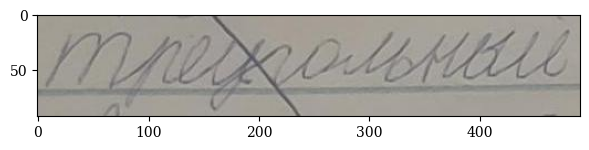

In [67]:
plt.imshow(Image.open(TRAIN_DATA_PATH + "223471.jpg"))

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [68]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

In [69]:
len(train_dataloader) * batch_size, len(val_dataloader) * batch_size

(271744, 2752)

In [70]:
len(train_dataloader) * batch_size + len(val_dataloader) * batch_size

274496

Запустим обучение (при параметрах по умолчанию эпоха занимает ~22 секунды на GPU):

In [71]:
import tqdm

crnn.train()
for epoch in range(num_epochs):
    epoch_losses = []

    for b in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt,  # N
                        zero_infinity=True)

        optimizer.zero_grad()
        loss.backward()
        
        # clip here
        torch.nn.utils.clip_grad_norm_(crnn.parameters(), 1.0) # or some other value

        optimizer.step()

        epoch_losses.append(loss.item())
    
    scheduler.step()  # Обновление скорости обучения

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {np.mean(epoch_losses):.4f}")
    print('-' * 10)

print('Training complete')

100%|██████████| 4246/4246 [09:41<00:00,  7.31it/s]


Adjusting learning rate of group 0 to 2.7000e-04.
Epoch 1/30 - Training Loss: 3.9935
----------


100%|██████████| 4246/4246 [08:00<00:00,  8.84it/s]


Adjusting learning rate of group 0 to 2.4300e-04.
Epoch 2/30 - Training Loss: 2.5325
----------


100%|██████████| 4246/4246 [07:55<00:00,  8.93it/s]


Adjusting learning rate of group 0 to 2.1870e-04.
Epoch 3/30 - Training Loss: 1.7454
----------


100%|██████████| 4246/4246 [07:45<00:00,  9.12it/s]


Adjusting learning rate of group 0 to 1.9683e-04.
Epoch 4/30 - Training Loss: 1.4417
----------


100%|██████████| 4246/4246 [07:44<00:00,  9.14it/s]


Adjusting learning rate of group 0 to 1.7715e-04.
Epoch 5/30 - Training Loss: 1.2742
----------


100%|██████████| 4246/4246 [07:54<00:00,  8.95it/s]


Adjusting learning rate of group 0 to 1.5943e-04.
Epoch 6/30 - Training Loss: 1.1588
----------


100%|██████████| 4246/4246 [07:43<00:00,  9.16it/s]


Adjusting learning rate of group 0 to 1.4349e-04.
Epoch 7/30 - Training Loss: 1.0700
----------


100%|██████████| 4246/4246 [07:46<00:00,  9.10it/s]


Adjusting learning rate of group 0 to 1.2914e-04.
Epoch 8/30 - Training Loss: 0.9934
----------


100%|██████████| 4246/4246 [07:47<00:00,  9.08it/s]


Adjusting learning rate of group 0 to 1.1623e-04.
Epoch 9/30 - Training Loss: 0.9238
----------


100%|██████████| 4246/4246 [07:54<00:00,  8.96it/s]


Adjusting learning rate of group 0 to 1.0460e-04.
Epoch 10/30 - Training Loss: 0.8609
----------


100%|██████████| 4246/4246 [08:01<00:00,  8.82it/s]


Adjusting learning rate of group 0 to 9.4143e-05.
Epoch 11/30 - Training Loss: 0.8046
----------


100%|██████████| 4246/4246 [08:14<00:00,  8.58it/s]


Adjusting learning rate of group 0 to 8.4729e-05.
Epoch 12/30 - Training Loss: 0.7482
----------


100%|██████████| 4246/4246 [07:52<00:00,  8.99it/s]


Adjusting learning rate of group 0 to 7.6256e-05.
Epoch 13/30 - Training Loss: 0.6976
----------


100%|██████████| 4246/4246 [07:51<00:00,  9.00it/s]


Adjusting learning rate of group 0 to 6.8630e-05.
Epoch 14/30 - Training Loss: 0.6487
----------


100%|██████████| 4246/4246 [07:47<00:00,  9.08it/s]


Adjusting learning rate of group 0 to 6.1767e-05.
Epoch 15/30 - Training Loss: 0.6027
----------


100%|██████████| 4246/4246 [07:50<00:00,  9.03it/s]


Adjusting learning rate of group 0 to 5.5591e-05.
Epoch 16/30 - Training Loss: 0.5578
----------


100%|██████████| 4246/4246 [07:55<00:00,  8.93it/s]


Adjusting learning rate of group 0 to 5.0032e-05.
Epoch 17/30 - Training Loss: 0.5155
----------


100%|██████████| 4246/4246 [07:59<00:00,  8.85it/s]


Adjusting learning rate of group 0 to 4.5028e-05.
Epoch 18/30 - Training Loss: 0.4753
----------


100%|██████████| 4246/4246 [07:48<00:00,  9.06it/s]


Adjusting learning rate of group 0 to 4.0526e-05.
Epoch 19/30 - Training Loss: 0.4381
----------


100%|██████████| 4246/4246 [07:52<00:00,  8.98it/s]


Adjusting learning rate of group 0 to 3.6473e-05.
Epoch 20/30 - Training Loss: 0.4035
----------


100%|██████████| 4246/4246 [07:58<00:00,  8.88it/s]


Adjusting learning rate of group 0 to 3.2826e-05.
Epoch 21/30 - Training Loss: 0.3705
----------


100%|██████████| 4246/4246 [07:48<00:00,  9.06it/s]


Adjusting learning rate of group 0 to 2.9543e-05.
Epoch 22/30 - Training Loss: 0.3420
----------


100%|██████████| 4246/4246 [07:42<00:00,  9.17it/s]


Adjusting learning rate of group 0 to 2.6589e-05.
Epoch 23/30 - Training Loss: 0.3157
----------


100%|██████████| 4246/4246 [07:44<00:00,  9.14it/s]


Adjusting learning rate of group 0 to 2.3930e-05.
Epoch 24/30 - Training Loss: 0.2913
----------


100%|██████████| 4246/4246 [07:45<00:00,  9.12it/s]


Adjusting learning rate of group 0 to 2.1537e-05.
Epoch 25/30 - Training Loss: 0.2692
----------


100%|██████████| 4246/4246 [07:44<00:00,  9.14it/s]


Adjusting learning rate of group 0 to 1.9383e-05.
Epoch 26/30 - Training Loss: 0.2504
----------


100%|██████████| 4246/4246 [07:45<00:00,  9.12it/s]


Adjusting learning rate of group 0 to 1.7445e-05.
Epoch 27/30 - Training Loss: 0.2329
----------


100%|██████████| 4246/4246 [07:35<00:00,  9.32it/s]


Adjusting learning rate of group 0 to 1.5700e-05.
Epoch 28/30 - Training Loss: 0.2173
----------


100%|██████████| 4246/4246 [07:39<00:00,  9.24it/s]


Adjusting learning rate of group 0 to 1.4130e-05.
Epoch 29/30 - Training Loss: 0.2037
----------


100%|██████████| 4246/4246 [07:33<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 1.2717e-05.
Epoch 30/30 - Training Loss: 0.1923
----------
Training complete


Провалидируем:

In [72]:
test_dataloader = val_dataloader

crnn.eval()
val_losses = []
for b in tqdm.tqdm(test_dataloader, total=len(test_dataloader)):
    images = b["image"].to(device)
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]

    with torch.no_grad():
        seqs_pred = crnn(images).cpu()
    log_probs = log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

    loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                    targets=seqs_gt,  # N, S or sum(target_lengths)
                    input_lengths=seq_lens_pred,  # N
                    target_lengths=seq_lens_gt,  # N
                    zero_infinity=True)  

    val_losses.append(loss.item())

print(f'Validation Loss: {np.mean(val_losses):.4f}')

100%|██████████| 43/43 [00:06<00:00,  6.19it/s]

Validation Loss: 1.2773


Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

In [73]:
y_ticks = ["-"] + [x for x in abc]

images = b["image"]
seqs_gt = b["seq"]
seq_lens_gt = b["seq_len"]
texts = b["text"]

preds = crnn(images.to(device)).cpu().detach()
texts_pred = decode(preds, crnn.alphabet)

In [74]:
texts_pred

['(205-12)',
 'И мы наменрувк',
 'INAIL',
 'учебников,',
 '270,000+',
 'нижних',
 'люди',
 'HASE',
 'гласно.)',
 'значительную',
 'устроить',
 'цвеета.',
 '3998-8118',
 'явтеелны вовои.',
 '12.10.1928',
 'овулукие',
 '252',
 'ПОДАЛ',
 'мосалетия',
 'Пемнста,',
 'Семин',
 'словам,',
 'дкивого',
 'Спера ичииль',
 '/',
 'у',
 '15002550869',
 'Вступая',
 'обспечение',
 '6126238000',
 'наблодатель',
 'ботествали',
 'Jecder',
 '930',
 '317',
 'гардали пирть мона',
 'R',
 'com',
 'мат',
 'правильные',
 'экаватар',
 'rnCANTo',
 'frei',
 'люди,',
 'лии',
 'Дилетрик',
 'область',
 'годах',
 'ВЛАДИКИВ',
 'ШиьДЫ,!]Я-[',
 'часто',
 'крепление',
 'Костанайская',
 '0566',
 'МОНППОЛИЯ',
 'DA',
 '"кроме',
 'по']

In [75]:
texts

['(2005–12)',
 'И мы ломаем руки,',
 'INAIL',
 'учебников,',
 '270,000+',
 'нижних',
 'люди',
 'HASE',
 'гласной.)',
 'значительную',
 'устроить',
 'цвета.',
 '3998-8118',
 'язвительным своим.',
 '18.10.1962',
 'КУРТКА',
 '152',
 'ПОДАЛ',
 'минометов.',
 'Темната,',
 'Семин',
 'словам,',
 'живого',
 'Сперва измучившись',
 '/',
 'у',
 '15002550869',
 'Вступая',
 'обеспечение',
 '616500027741',
 'наблюдатель',
 'божествам',
 'Jeder',
 '930',
 '317',
 'терзали жизнь мою',
 'R',
 'com',
 'мат',
 'правильные',
 'Эскаватор',
 'incanto',
 'frei',
 'люди,',
 'лиц',
 'Диэлектрик',
 'область',
 'ГОДАХ',
 'ВЛАДИСЛАВ',
 '|ЩыъПЛш.>юЖ–в`Г',
 'часто',
 'крепление',
 'Костанайская',
 '0566',
 'монополия',
 'DA',
 '"кроме',
 'по']

### Submission

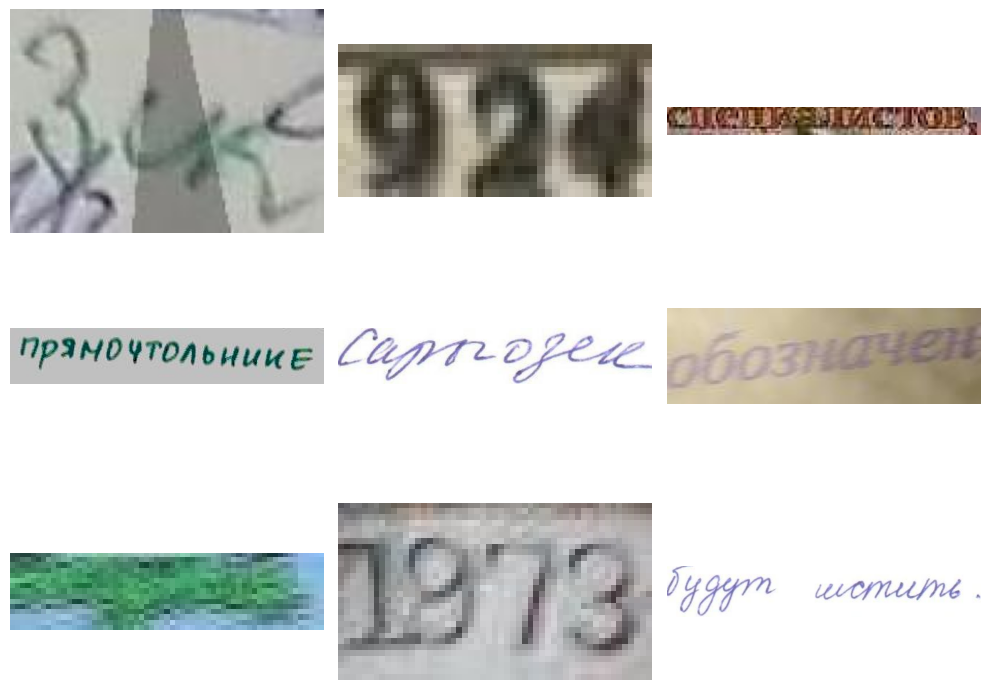

In [76]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

for i, ax in enumerate(axs.flatten()):
    img_name = ["49917.jpg", "10.jpg", "100.jpg", "1000.jpg", "10000.jpg", "40874.jpg", "10017.jpg", "10049.jpg", "10019.jpg"] 
    img = Image.open(TEST_DATA_PATH + img_name[i])
    
    # отобразить изображение
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [77]:
def predict(path_image, model):
#     image = cv2.imread(path_image).astype(np.float32) / 255.
    image, rotated = load_image(path_image)
    item = dict(image=image)
    item = data_transforms["validation"](item)
    image_tensor = torch.from_numpy(item["image"]).permute(2, 0, 1).float()
    image_tensor = image_tensor.unsqueeze(0)  
    preds = model(image_tensor.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)

    return texts_pred

In [78]:
predict(TEST_DATA_PATH + "10049.jpg", crnn)

['1973']

In [79]:
import os

submission = {}

# Получение списка файлов в директории
files = os.listdir(TEST_DATA_PATH)

# Проход циклом по файлам с прогресс-баром
for file in tqdm.tqdm(files, total=len(files)):
    # Проверка, что файл является изображением (пример: проверка расширения файла)
    if file.endswith(".jpg") or file.endswith(".png"):
        # Полный путь к файлу
        file_path = os.path.join(TEST_DATA_PATH, file)
        
        submission[file] = predict(file_path, crnn)[0]

100%|██████████| 52999/52999 [11:21<00:00, 77.78it/s]


In [80]:
df = pd.DataFrame(submission.items(), columns=['Id', 'Predicted'])
df.head()

,Id,Predicted
0,31973.jpg,"КНАЧ,"
1,30778.jpg,В
2,19812.jpg,AUTO ACCSOONES
3,22735.jpg,L41
4,38246.jpg,Entrynca


In [81]:
df.to_csv('/kaggle/working/submission.csv', index=False)

In [82]:
torch.save(crnn.state_dict(), 'crnn_resnet.pth')

### CER

1. Что сдлать ctc loss + beam searc, mobile net, менее сложный sequence predictor, gru -> lstm
2. train_labels[train_labels["Expected"]=='None'] убрать None

In [83]:
import Levenshtein

def compute_cer(img_name, train_labels):
    target = train_labels[train_labels["Id"]==img_name]["Expected"].values[0].lower()
    prediction = predict(TRAIN_DATA_PATH + img_name, crnn)[0].lower()
    cer = Levenshtein.distance(target, prediction) / len(target)
    return cer

[]


['предкольным']

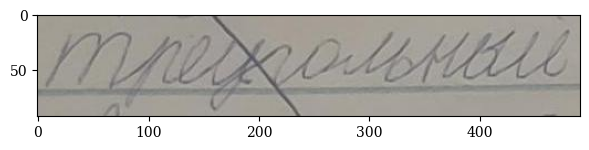

In [84]:
img_name = "223471.jpg"
plt.imshow(Image.open(TRAIN_DATA_PATH + img_name))
print(train_labels[train_labels["Id"]==img_name]["Expected"].values)
predict(TRAIN_DATA_PATH + img_name, crnn)

In [85]:
compute_cer(img_name, train_labels)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [86]:
train_labels[train_labels["Expected"]=='None']

,Id,Expected,Expected_Length,file,text


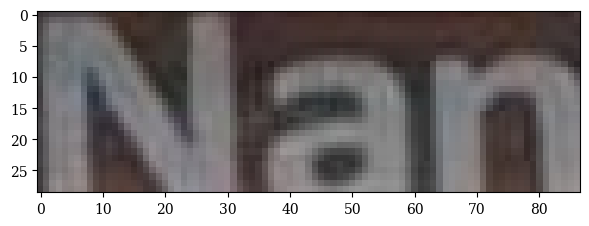

In [87]:
plt.imshow(Image.open(TRAIN_DATA_PATH + "244733.jpg"))

In [95]:
dff=train_labels.sample(100_000)
dff

,Id,Expected,Expected_Length,file,text
241315,241316.jpg,HUHONG,6,/kaggle/input/vk-ocr/train/train/241316.jpg,HUHONG
143315,143316.jpg,поисках,7,/kaggle/input/vk-ocr/train/train/143316.jpg,поисках
264647,264648.jpg,18260293655,11,/kaggle/input/vk-ocr/train/train/264648.jpg,18260293655
167289,167290.jpg,Холланд,7,/kaggle/input/vk-ocr/train/train/167290.jpg,Холланд
93424,93425.jpg,"""На",3,/kaggle/input/vk-ocr/train/train/93425.jpg,"""На"
...,...,...,...,...,...
125627,125628.jpg,1.39,4,/kaggle/input/vk-ocr/train/train/125628.jpg,1.39
271927,271928.jpg,"стрекозы,",9,/kaggle/input/vk-ocr/train/train/271928.jpg,"стрекозы,"
188417,188418.jpg,напоминая,9,/kaggle/input/vk-ocr/train/train/188418.jpg,напоминая
158672,158673.jpg,-урожай,7,/kaggle/input/vk-ocr/train/train/158673.jpg,-урожай


In [96]:
import tqdm
from IPython.display import clear_output

img_names_with_high_cer = []

with tqdm.tqdm(total=len(dff), desc="Computing CER", bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt}') as pbar:
    for img_name in dff["Id"]:
        cer = compute_cer(img_name, dff)
        if cer > 1.0:
            img_names_with_high_cer.append(img_name)
        
        clear_output(wait=True)  # Очищаем вывод ячейки
        pbar.update(1)

Computing CER:   1%|          | 772/100000


KeyboardInterrupt: 

In [94]:
img_names_with_high_cer

[]

['Готовился']


['Готовился']

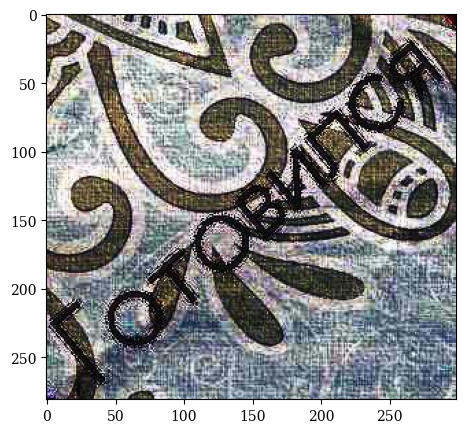

In [92]:
img_name = "3535.jpg"
plt.imshow(Image.open(TRAIN_DATA_PATH + img_name))
print(train_labels[train_labels["Id"]==img_name]["Expected"].values)
predict(TRAIN_DATA_PATH + img_name, crnn)

In [284]:
train_labels[train_labels['text']=='ТЕН']

,Id,Expected,Expected_Length,file,text
206825,206826.jpg,ТЕН,3,/kaggle/input/vk-ocr/train/train/206826.jpg,ТЕН
271073,271074.jpg,ТЕН,3,/kaggle/input/vk-ocr/train/train/271074.jpg,ТЕН


['R']


['®']

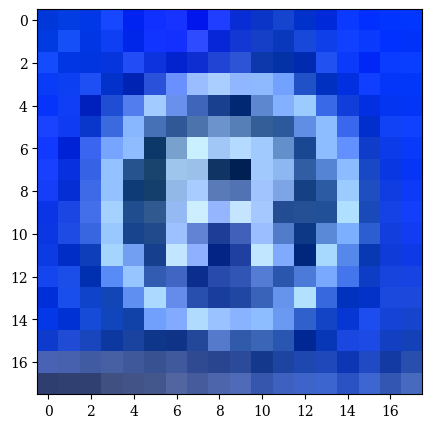

In [232]:
img_name = "71112.jpg"
plt.imshow(Image.open(TRAIN_DATA_PATH + img_name))
print(train_labels[train_labels["Id"]==img_name]["Expected"].values)
predict(TRAIN_DATA_PATH + img_name, crnn)

In [197]:
abc.find('®')

216

In [97]:
train_labels

,Id,Expected,Expected_Length,file,text
0,1.jpg,Атырау,6,/kaggle/input/vk-ocr/train/train/1.jpg,Атырау
1,2.jpg,транз,5,/kaggle/input/vk-ocr/train/train/2.jpg,транз
2,3.jpg,ходят,5,/kaggle/input/vk-ocr/train/train/3.jpg,ходят
3,4.jpg,"ощущений,",9,/kaggle/input/vk-ocr/train/train/4.jpg,"ощущений,"
4,5.jpg,74,2,/kaggle/input/vk-ocr/train/train/5.jpg,74
...,...,...,...,...,...
275995,275996.jpg,DO,2,/kaggle/input/vk-ocr/train/train/275996.jpg,DO
275996,275997.jpg,BASUCC,6,/kaggle/input/vk-ocr/train/train/275997.jpg,BASUCC
275997,275998.jpg,"1,120",5,/kaggle/input/vk-ocr/train/train/275998.jpg,"1,120"
275998,275999.jpg,"наблюдателей,",13,/kaggle/input/vk-ocr/train/train/275999.jpg,"наблюдателей,"


In [104]:
dff = train_labels.sample(10000)

In [107]:
from tqdm import tqdm
tqdm.pandas()

dff["preds"] = dff["Id"].progress_apply(lambda x: predict(TRAIN_DATA_PATH + x, crnn)[0])

100%|██████████| 10000/10000 [01:00<00:00, 165.95it/s]


In [124]:
dff[dff["text"]!=dff["preds"]][70:100]

,Id,Expected,Expected_Length,file,text,preds
98079,98080.jpg,Дремля смолкнул,15,/kaggle/input/vk-ocr/train/train/98080.jpg,Дремля смолкнул,Дремля слокнул
273913,273914.jpg,помимо воя,10,/kaggle/input/vk-ocr/train/train/273914.jpg,помимо воя,полимо воя
51799,51800.jpg,моей лежит,10,/kaggle/input/vk-ocr/train/train/51800.jpg,моей лежит,мей лежит
249889,249890.jpg,24`х,4,/kaggle/input/vk-ocr/train/train/249890.jpg,24`х,24’х
2419,2420.jpg,"ПUШUТE,",7,/kaggle/input/vk-ocr/train/train/2420.jpg,"ПUШUТE,","ПUWUTE,"
171184,171185.jpg,Ёф8“,4,/kaggle/input/vk-ocr/train/train/171185.jpg,Ёф8“,Ёф8*
255944,255945.jpg,ЬтйвЗ0+І,8,/kaggle/input/vk-ocr/train/train/255945.jpg,ЬтйвЗ0+І,ЬтйвЗ0+%
64584,64585.jpg,"`>”ьм«}*.“лт'г""",15,/kaggle/input/vk-ocr/train/train/64585.jpg,"`>”ьм«}*.“лт'г""","’%ьм""!’лг"""
33937,33938.jpg,разросшихся хвощах,18,/kaggle/input/vk-ocr/train/train/33938.jpg,разросшихся хвощах,разросшихя хвощах
184079,184080.jpg,TCLIMATE JKET,13,/kaggle/input/vk-ocr/train/train/184080.jpg,TCLIMATE JKET,TLMAE JKET


['Discovering']


['Discdverung']

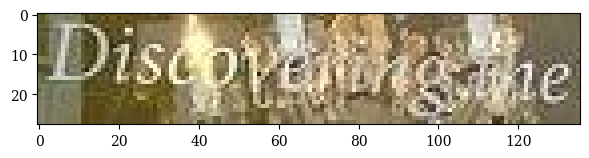

In [126]:
img_name = "109705.jpg"
plt.imshow(Image.open(TRAIN_DATA_PATH + img_name))
print(train_labels[train_labels["Id"]==img_name]["Expected"].values)
predict(TRAIN_DATA_PATH + img_name, crnn)

### 6. Что делать дальше?

- При обучении и валидации мы смотрели только на значение функции потерь. Обычно принято для оценки качества моделей использовать какую-либо репрезентативную метрику. Реализуйте подсчет `Accuracy` (доля верно предсказанных номеров) на обучающей и валидационной выборке.
- Как можно видеть по последним картинкам, наша модель почти ничего не предсказывает в середине последовательности (предсказывает `blank`). Попробуйте изменить архитктуру (или поиграйтесь с параметрами текущей) модели, чтобы более эффективно использовать ее.
- Проанализируйте, на каких примерах валидационной (и обучающей) выборки модель ошибается? Что можно сделать, чтобы полечить эти проблемы?
- Мы не умеем оценивать, насколько адекватны предсказания модели. Подумайте, как можно оценить "уверенность" модели в собственных предсказаниях?
- Вспомните, что мы оставили в выборке только "стандартные" номера. Попробуйте вернуть в обучение более сложные классы и обучить модель. Что получится?